# Descripción

Para esta sesión trabajaremos con la base de datos sobre cáncer mamario de Wisconsin. El objetivo
es desarrollar un Clasificador mediante Máquinas de Soporte de Vectores que predica de forma
adecuada en base a una serie de atributos sobre la composición del núcleo de una célula mamaria

# Ejercicio 1: Preparar el ambiente de trabajo

Importe todas las librerías a utilizar.

* Fije los parámetros de los gráficos con plt.Rcparams .

* Excluya las columnas id y Unnamed: 32 de la base de datos.

* Recodifique el vector objetivo diagnosis a numérico para poder procesarlo posteriormente.

In [101]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
warnings.simplefilter('ignore')
plt.rcParams['figure.figsize']=(10,6)
plt.style.use('seaborn')

In [102]:
df= pd.read_csv('breast_cancer.csv').drop(columns=['id','Unnamed: 32'])

In [103]:
lbl=LabelEncoder()
df['diagnosis']=lbl.fit_transform(df['diagnosis'])

In [104]:
print(lbl.classes_)

['B' 'M']


In [105]:
df.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Ejercicio 2: Visualizando la distribución de los atributos

* Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector
  objetivo.
  
  
* Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con
  una mayor similitud en la distribución.

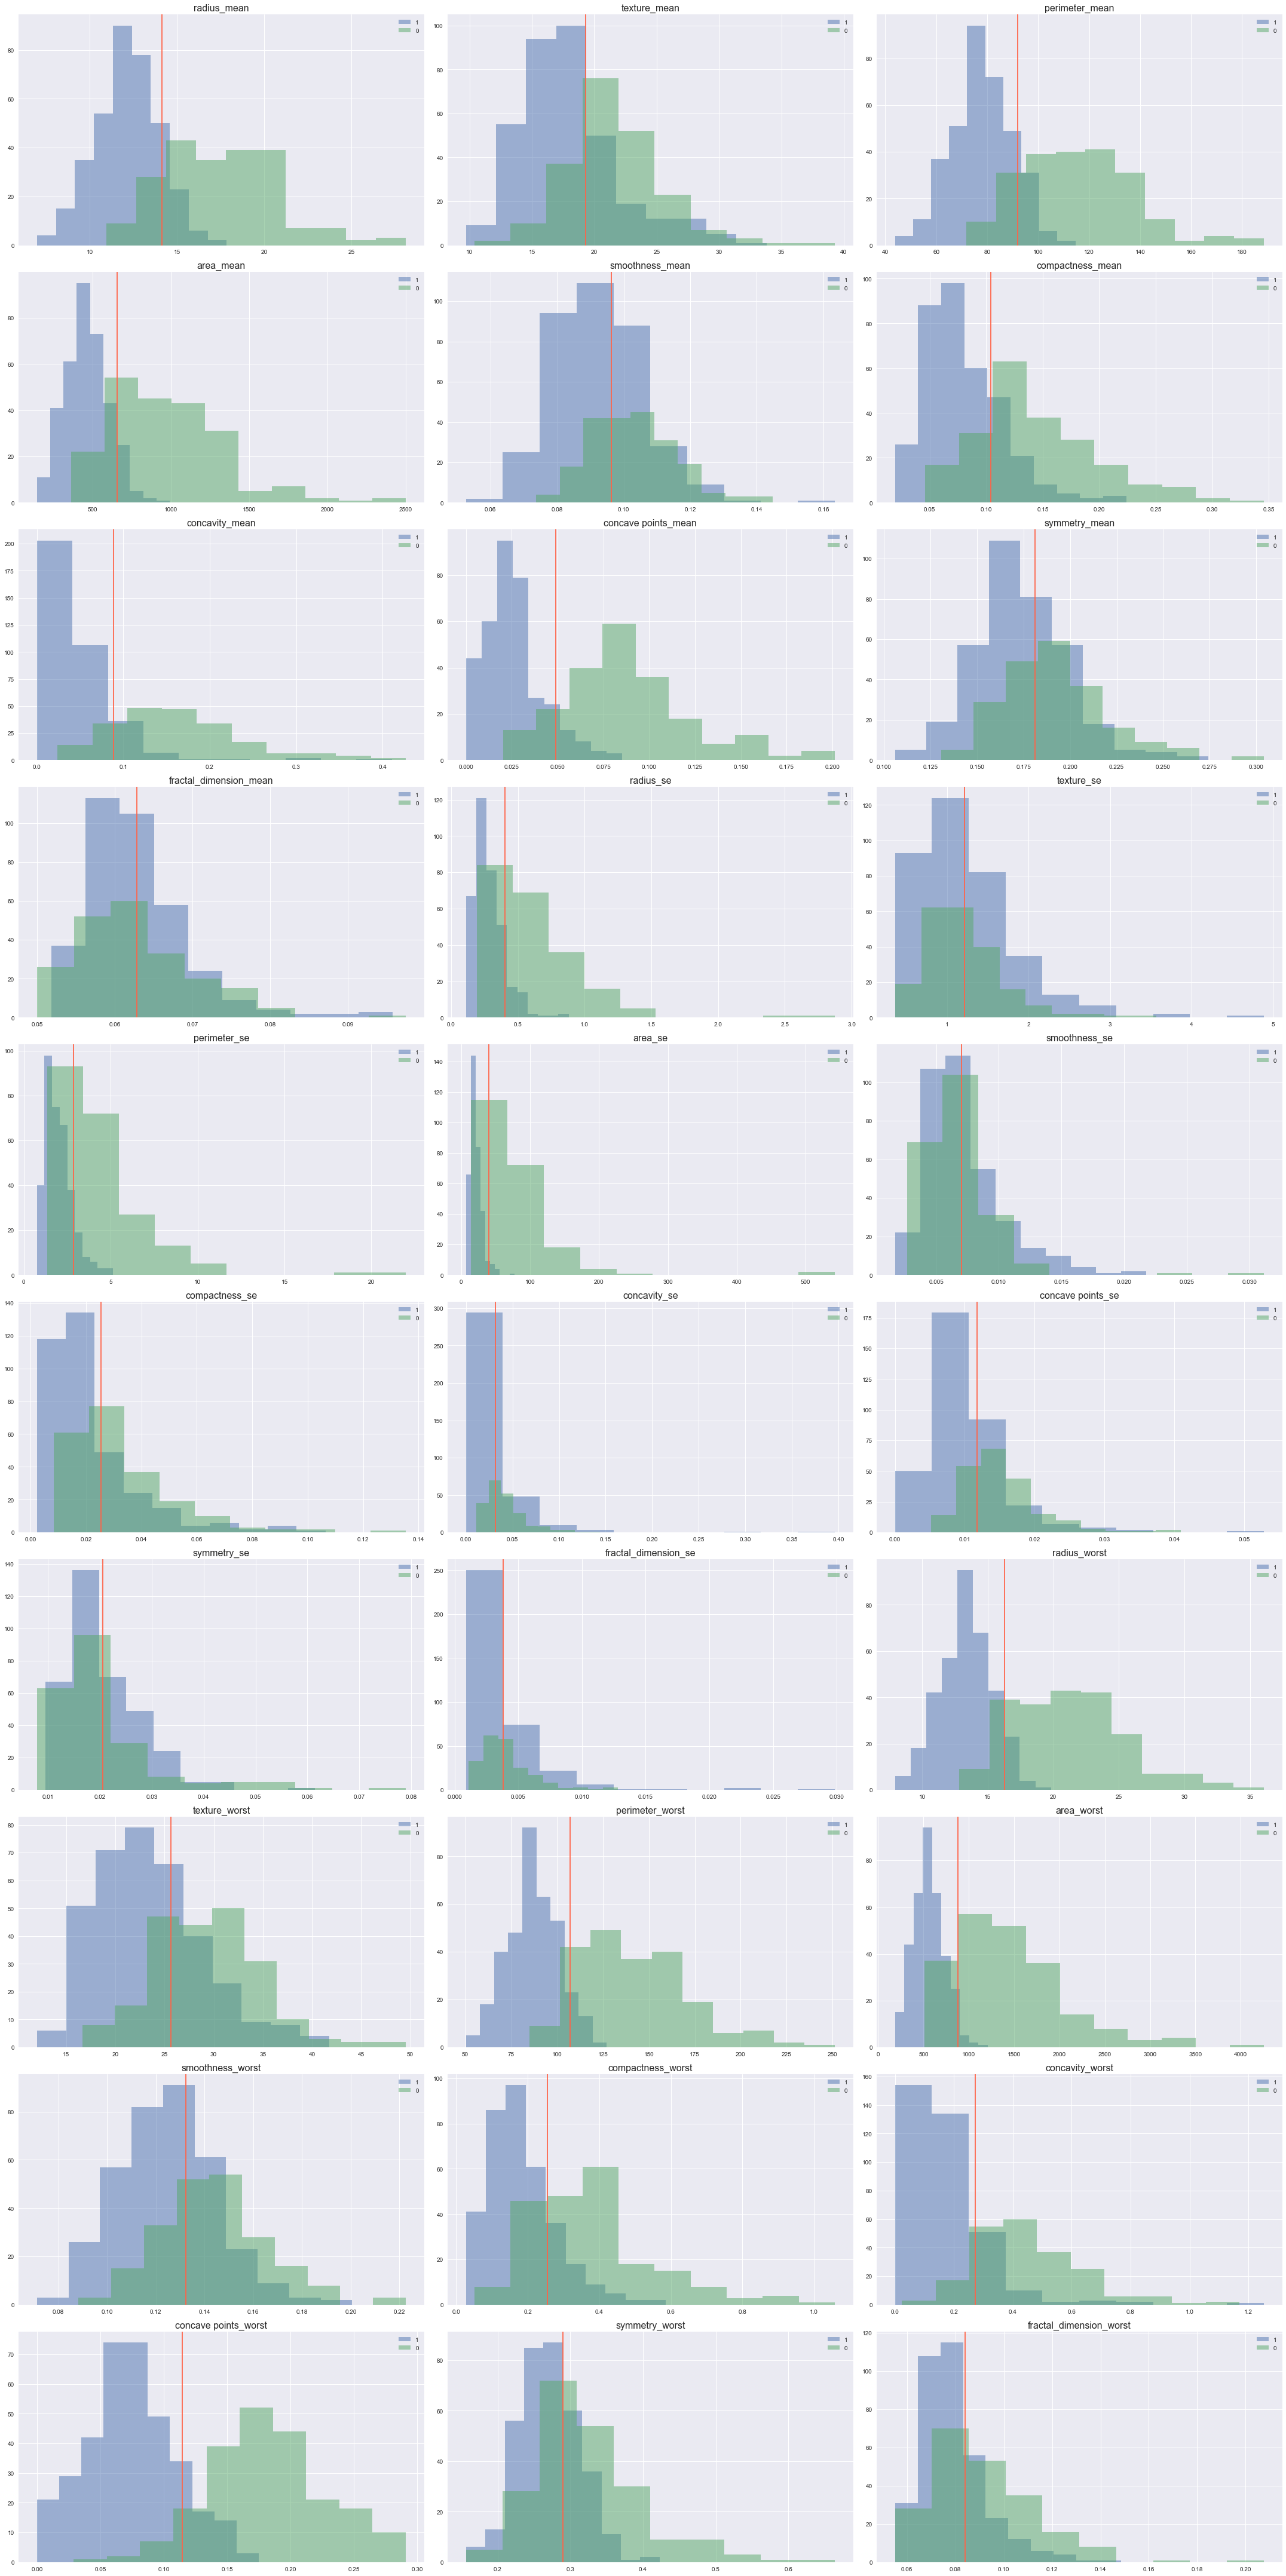

In [106]:
plt.rcParams['figure.figsize']=(30,60)

n=0
for index,(colname,serie) in enumerate(df.loc[:,'radius_mean':'fractal_dimension_worst'].iteritems()):
    plt.subplot(10,3,n+1)
    if pd.api.types.is_float_dtype(serie) is True:
        df.groupby('diagnosis')[colname].plot(kind='hist',alpha=.5)
    elif pd.api.types.is_integer_dtype(serie) is True:
        df.groupby('diagnosis')[colname].plot(kind='bar',alpha=.5)

    plt.title('Frecuencias para {}'.format(i))
    plt.legend(df['diagnosis'].unique())
    plt.axvline(np.mean(serie),color='tomato',label='media')
    plt.title(colname,fontsize=16)
    plt.xlabel(''); plt.ylabel(''); plt.tight_layout()
    n=n+1

De los gráficos, podemos ver que las cariables concave points_mean, concavity_mean, perimeter_worst, concavity_worst y concave points_worst, presentan una separación más marcada entre clases que las demás, lo que podría facilitar la generación de una recta que divida ambas clases en las ellas. Por el contrario, las variables smothness_mean, symmetry_mean, fractal_dimension_mean, texture_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, smothness_worst, symmetry_worst y fractal_dimension_worst poseen distribuciones similares en ambas clases, lo que dificultará el encontrar una recta que separe ambas clases.

# Ejercicio 3: Estimando el porcentaje de overlap en los atributos

* Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases
    no separables mediante el proceso de kernelización. Resulta que un aspecto importante que
    muchas veces se obvía es medir la no se parabilidad de los atributos, condicional a cada clase
    del vector objetivo.


* El procedimiento para estimar el rango de noseparabilidad entre clases se implementa en
  Python de la siguiente manera:

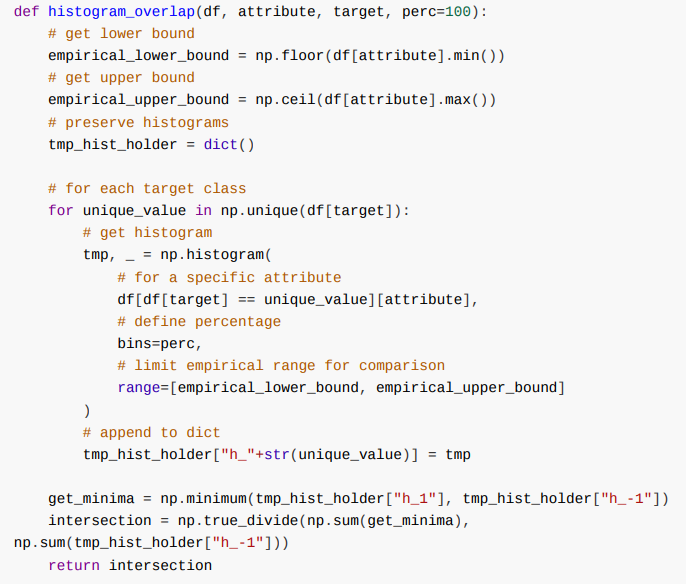


* La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde mayores
    niveles indican una mayor comunalidad.
    
    

* Utilizando la función, genere un dataframe donde almacenará el nombre del atributo y su
    porcentaje. Ordene este dataframe de forma descendente y preserve.


In [107]:
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    
    
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound])
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima),
    np.sum(tmp_hist_holder["h_0"]))
    return intersection

In [108]:
atributo=[]
porcentaje=[]

columns=df.columns

for i in columns[1:]:
    porcentaje.append(histogram_overlap(df, i, columns[0], perc=100))
    atributo.append(i)

In [109]:
d={'atributo':atributo, 'porcentaje':porcentaje}
data=pd.DataFrame(d).sort_values(by='porcentaje', ascending=False)

In [110]:
data

,atributo,porcentaje
19,fractal_dimension_se,0.593838
14,smoothness_se,0.591036
9,fractal_dimension_mean,0.588235
18,symmetry_se,0.568627
11,texture_se,0.549020
15,compactness_se,0.523810
4,smoothness_mean,0.521008
8,symmetry_mean,0.509804
17,concave points_se,0.507003
29,fractal_dimension_worst,0.492997


# Ejercicio 4: Selección del modelo por GridSearchCV

Entrene una serie de modelos SVC con los siguientes hiperparámetros:

* C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] .
* gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10] .
* Validaciones cruzadas: 10.

Genere un heatmap en base a los puntajes estimados con GridSearchCV .


tip: Vea cómo acceder a la llave mean_test_score en el diccionario cv_results_ .

In [126]:
X_train, X_test, y_train, y_test =train_test_split(df.loc[:,'radius_mean':'fractal_dimension_worst'], df["diagnosis"],
                                                   test_size=.30,random_state=17127)

In [127]:
params= {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'gamma':[0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [128]:
estimate=GridSearchCV(SVC('kbf'),params,cv=10)

In [129]:
estimate.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVC(C='kbf'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1, 1, 10]})

In [130]:
score=estimate.cv_results_['mean_test_score'].reshape(8,7)

Text(0.5, 1, 'Accuracy Heatmap')

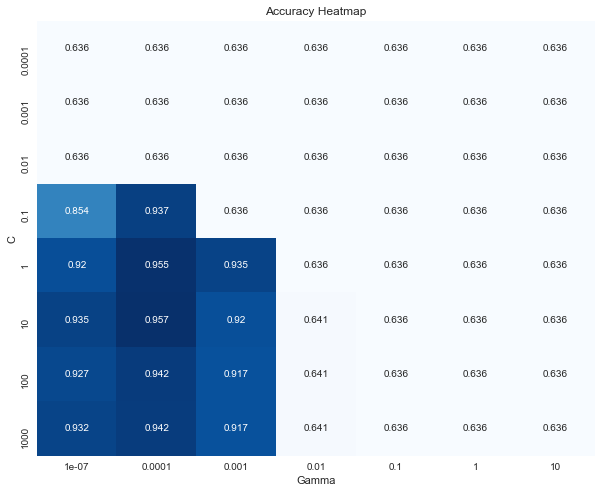

In [131]:
plt.rcParams['figure.figsize']=(10,8)
sns.heatmap(score,annot=True,cmap='Blues',cbar=False,fmt='.3',
            xticklabels=[0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            yticklabels=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy Heatmap')